#**<font color='yellow'>Model Name: InceptionV3</font>**
##**Date: 21<sup>st</sup>January 2020**

### **Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####**Import Necessary Library**

In [2]:
import numpy as np
import cv2
import os
import pandas as pd

import glob as gb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D ,LeakyReLU

####**Define directories path**

In [4]:
## Define the directories for training, testing, and validation
train_directory = '/content/drive/MyDrive/Fish/train'
test_directory = '/content/drive/MyDrive/Fish/test'
valid_directory = '/content/drive/MyDrive/Fish/valid'

####**Create dataset function using keras/Tensorflow**

In [5]:
IMG_SIZE = (299, 299)  # define resolution (299,299) /(224,224)
BATCH_SIZE = 128       # varies from dataset to datset prefferable 128/68/32

In [6]:
# Create TensorFlow datasets for training, testing, and validation
#you can customize as per dataset
train_dataset = image_dataset_from_directory(
    train_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

test_dataset = image_dataset_from_directory(
    test_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

valid_dataset = image_dataset_from_directory(
    valid_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

Found 15 files belonging to 3 classes.
Found 6 files belonging to 3 classes.
Found 9 files belonging to 3 classes.


In [7]:
# Optional: You can also specify the class names if you have a specific order for your classes
class_names = train_dataset.class_names

# Print class names
print("Class Names:", class_names)

Class Names: ['Argulus', 'EUS', 'Healthy Fish']


In [ ]:
x=list(class_names)
x

['Argulus', 'EUS', 'Healthy Fish']

In [ ]:
x=list(range(len(class_names)))
x

[0, 1, 2]

<ipython-input-9-507749f1f0f7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_names), y=Dataset, palette="rocket")


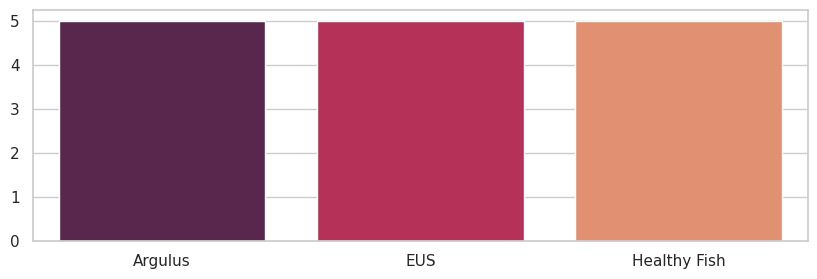

In [9]:
#plot bar chart for demonstrating data size
sns.set_theme(style="whitegrid")
Dataset = []
for folder in os.listdir(train_directory):
    files = gb.glob(pathname=str(train_directory + "/" + folder +"/*.*"))
    Dataset.append(len(files))
plt.figure(figsize=(10,len(class_names)))                    ## change the len size
#sns.barplot(x=[ "0","1","2"], y=Dataset, palette="rocket")  ## change the class name
sns.barplot(x=list(class_names), y=Dataset, palette="rocket")
plt.show()

## <font color='blue'>Build the Model</font>

In [10]:
base_learning_rate = 0.001 # prefferable lr is 0.0001 or 0.001
IMG_SHAPE = IMG_SIZE +(3,)

In [11]:
## N.B:download the weights (imagenet/...) and model (Resnet50/ResNet100/InceptionV3...)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False, weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [12]:
type(base_model)
## N.B: changle the model name
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [13]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name)

Numbers of Layers = 311
activation_93
mixed10


In [14]:
# iterate over first batch (32 image) in trainset
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(15, 8, 8, 2048)


In [15]:
def create_model( image_shape=IMG_SHAPE):
    ''' Define a tf.keras model for multi-class classification out of the *model name* (Resnet/Inception...) '''
    ##change the *model name*
    downloaded_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False, weights='imagenet')
    downloaded_model.trainable = True
    for layer in downloaded_model.layers[0 : 291]:
        layer.trainable = False

    inputs = tf.keras.Input(image_shape)
    x = preprocess_input(inputs)
    x = downloaded_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    prediction_layer = tf.keras.layers.Dense(len(class_names) ,activation = "softmax")   ## change the first parameter according to the class len
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    return model

In [16]:
## specify function name as model name
model = create_model(IMG_SHAPE)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 299, 299, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 299, 299, 3)       0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                             

In [17]:
## customize optimizer as Nadam or Adam
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

In [52]:
from tensorflow.keras.callbacks import ModelCheckpoint
## set the path name as *dataset/Lr/optimizer_name/model_name*
model_filepath="/content/drive/MyDrive/dataset/Lr/optimizer_name/model_name-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath = model_filepath ,
    monitor ='val_accuracy',
    mode = 'max' ,
    save_best_only =True ,
    verbose = 1
)

In [26]:
weight_for_=[0] * len(Dataset)
total = 0
for i in range(0,len(Dataset )) :
    total +=Dataset [i]

for i in range(0,len(Dataset)):
  weight_for_[i]= (1.00/ Dataset[i]) * (total / float(len(class_names)))

In [31]:
class_weight = {}
for i, weight in enumerate(weight_for_):
    class_weight[i] = weight


In [33]:
for i in range(0,len(Dataset)):
  print('Weight for class [i]: {:.2f}'.format(weight_for_[i]))

Weight for class [i]: 0.00
Weight for class [i]: 0.00
Weight for class [i]: 0.00


In [35]:
for class_index, weight in class_weight.items():
    print(f"Weight for Class {class_index}: {weight}")


Weight for Class 0: 0
Weight for Class 1: 0
Weight for Class 2: 0


In [29]:
weight_for_=[0] * len(Dataset)
print(weight_for_)

[0, 0, 0]


In [25]:
print(len(Dataset ))

3


In [23]:
total = 0
for i in range(0,len(Dataset )) :
    total +=Dataset [i]
    print(total)

5
10
15


In [21]:
print(float(len(class_names)))

3.0


In [ ]:
#avoid random weight initialization do automatic if you can

total = 0
for i in range(0,len(Dataset )) :
    total +=Dataset [i]

weight_for_0 = (1 / Dataset [0]) * (total / 3.0)
weight_for_1 = (1 / Dataset [1]) * (total / 3.0)
weight_for_2 = (1 / Dataset [2]) * (total / 3.0)


class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

In [70]:
# Initialize an empty dictionary to store class weights
class_weight = {}

# Calculate the total sum of all samples in the dataset
total_samples = sum(Dataset)

# Calculate weights for each class
for i in range(0, len(Dataset)):
    weight_for_i = (1 / Dataset[i]) * (total_samples / float(len(class_names)))
    class_weight[i] = weight_for_i

# Print the weights for each class
for class_index, weight in class_weight.items():
    print('Weight for class {}: {:.2f}'.format(class_index, weight))


Weight for class 0: 1.00
Weight for class 1: 1.00
Weight for class 2: 1.00


####**Training model**

In [53]:
## change hyperparameter such as epoches
history = model.fit(train_dataset , verbose=2 , epochs=2 , class_weight=class_weight ,
                               validation_data=valid_dataset , use_multiprocessing= True, callbacks =[checkpoint])

Epoch 1/2

Epoch 1: val_accuracy improved from -inf to 0.22222, saving model to /content/drive/MyDrive/dataset/Lr/optimizer_name/model_name-01-0.2222.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 - 15s - loss: 0.0105 - accuracy: 1.0000 - val_loss: 2.0601 - val_accuracy: 0.2222 - 15s/epoch - 15s/step
Epoch 2/2

Epoch 2: val_accuracy did not improve from 0.22222
1/1 - 7s - loss: 0.0371 - accuracy: 1.0000 - val_loss: 2.2988 - val_accuracy: 0.2222 - 7s/epoch - 7s/step


In [40]:
model.evaluate(test_dataset , verbose = 1)

1/1 [==============================] - 2s 2s/step - loss: 0.6936 - accuracy: 0.6667


[0.6936309337615967, 0.6666666865348816]

###**Model evaluating on Test dataset**

1/1 [==============================] - 0s 458ms/step


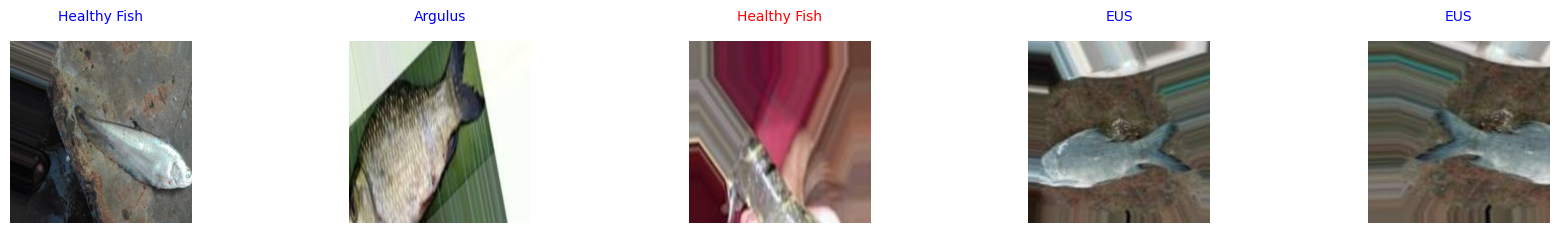

In [44]:
plt.figure(figsize=(20, 15))
for images, labels in test_dataset.take(1):
    for i in range(5):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = model.predict(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        if (actual == predicted):
            plt.title(predicted, fontsize=10, color= 'blue', pad=15);
        else :
            plt.title(actual, fontsize=10, color= 'red' ,pad=15);
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,
                            top=0.9, wspace=0.4,hspace=0.4)

###**<font color='green'>Training and Validation Accuracy </font> & <font color='red'>Training and Validation Loss </font>**

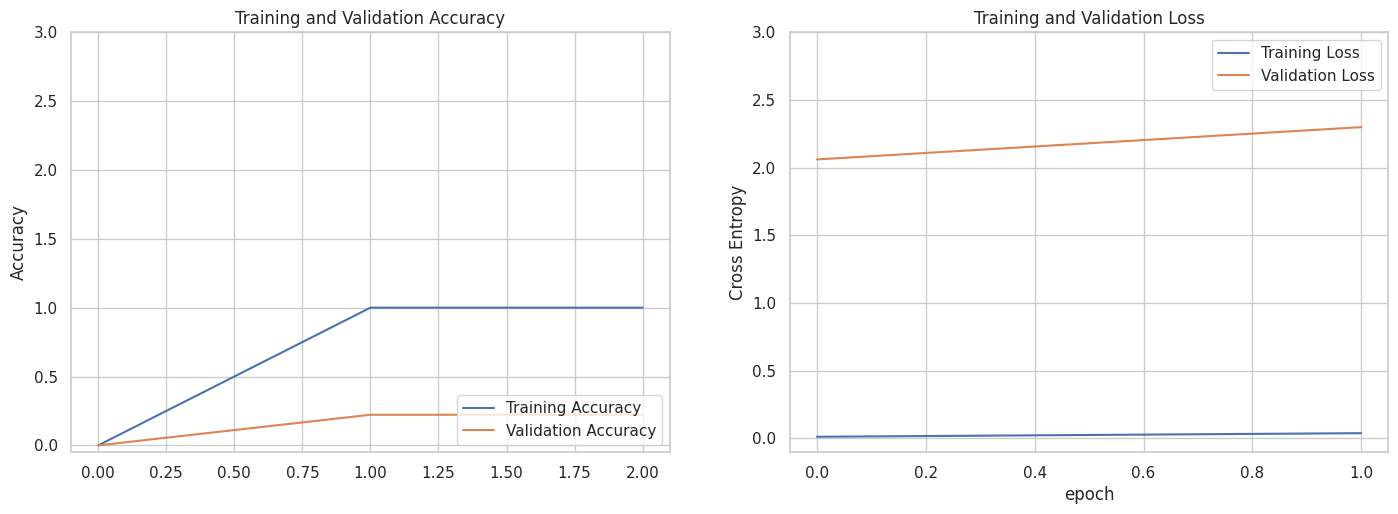

In [65]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))

plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),3])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),3])
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

###**True and Predicted labels**

In [46]:
from sklearn.preprocessing import label_binarize

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset and make predictions
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Binarize the true and predicted labels
true_labels_bin = label_binarize(true_labels, classes=np.unique(true_labels))
predicted_labels_bin = label_binarize(predicted_labels, classes=np.unique(predicted_labels))

1/1 [==============================] - 6s 6s/step


###**Classification Report**

In [47]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)

              precision    recall  f1-score   support

     Argulus       0.50      0.50      0.50         2
         EUS       1.00      1.00      1.00         2
Healthy Fish       0.50      0.50      0.50         2

    accuracy                           0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



###**ROC Curve for Multiclass Classification**

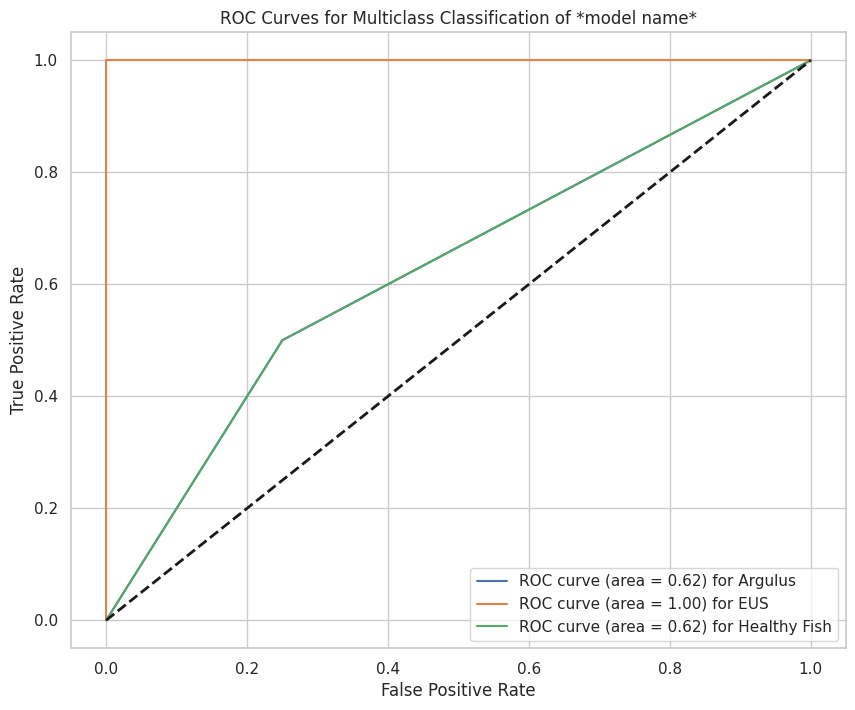

ROC AUC for Argulus: 0.6250
ROC AUC for EUS: 1.0000
ROC AUC for Healthy Fish: 0.6250


In [48]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Compute class-specific ROC AUC values
roc_auc_per_class = []
for i in range(len(class_names)):
    roc_auc = roc_auc_score(true_labels_bin[:, i], predicted_labels_bin[:, i])
    roc_auc_per_class.append(roc_auc)

# Plot class-specific ROC curves
plt.figure(figsize=(10, 8))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], predicted_labels_bin[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
##change the model name
plt.title('ROC Curves for Multiclass Classification of *model name*')
plt.legend(loc='lower right')
plt.show()

# Print class-specific ROC AUC values
for i in range(len(class_names)):
    print(f'ROC AUC for {class_names[i]}: {roc_auc_per_class[i]:.4f}')

### **Confusion Matrix**

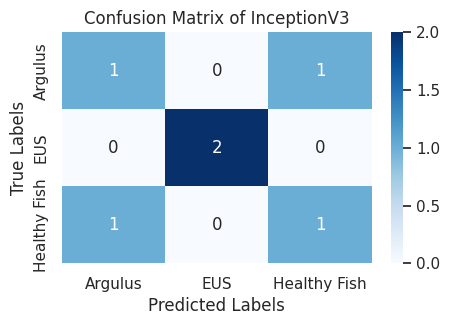

In [49]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
## change the model name
plt.title('Confusion Matrix of InceptionV3')
plt.show()

###**Cohen's Kappa**

In [50]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(true_labels, predicted_labels)
print(f'Cohen\'s Kappa: {kappa:.4f}')

Cohen's Kappa: 0.5000


###**Matthews Correlation Coefficient (MCC)**

In [51]:
from sklearn.metrics import matthews_corrcoef
import numpy as np

# Assuming true_labels and predicted_labels are multiclass labels
mcc_values = [matthews_corrcoef(true_labels == i, predicted_labels == i) for i in np.unique(true_labels)]

average_mcc = np.mean(mcc_values)
print(f'Average Matthews Correlation Coefficient for Multiclass: {average_mcc:.4f}')

Average Matthews Correlation Coefficient for Multiclass: 0.5000
